# Sequence classification using CNNs

Welcome the sequence classification. In the next few hours, we will go through three notebooks in which you will learn how to classify RNA sequences using Convolutional Neural Networks (CNNs).

Key Points:

**1_data_processing**: Read in the data; Visualize sequence properties; Create 'naive' baseline predictions;

**2_cnn_classification**: Compare different input transformation; Classify sequences using simple CNNs; Cross-validate results; Use Grid-Search for model optimization; 

**3_cnn_classification_structure**: Using secondary structure for prediction; Combining sequence and structure information with Early and Late Integration;

Throughout the notebooks you will need to fill in blanks. These will be marked using XXXX and usually marked with a comment, what you need to fill in this spot.



---

# 1 Data Processing to generate sequence files for our CNN

## Read in the sequence data

We want to classify snoRNA families (C/D-box and H/ACA-box) as well as the related scaRNA family using the nucleotide sequences consisting of A,C,G and T. Nucleotide sequences are usually saved in a file format called ".fasta". A fasta file is defined by a header line starting with ">" and one or multiple lines of nucelotide sequence until the next header starts.

`>sequence_id description`

`nucleotide sequence`

For Example:

`>URS0000A97CA8_9358 snoRNA`

`CGGGCCCTGAATCAGGACCAGTAGTTTGCTGTATCGTTAGTTTTAAAAAAGAGCCAAGAG`

`CTAATTCTTCTTATGATTGGCTATTCAGTACCATAGTAAGGAATGGCCCCTTCATTTGGA`

`AAAAACAGTC`

As we need to preprocess our input before we can train or validate our machine learning models like Convolutional Neural Networks we have to import the data. First, we will have to read in the data using BioPython's method `SeqIO.parse()`. The sequences should be saved in a dictionary, where the key is the RNAcentral ID from the header and the value is the nucleotide sequence, saved as a string and turned to upper case letters. We do this for all sequences in the fasta file. 

Next, we will transform our dictionary into a dataframe, using pandas `DataFrame.from_dict()` method. Make sure you orient the dataframe by index and name the column "sequence". 

Do these steps for all three fasta files. 

In [1]:
from Bio import SeqIO

haca_dict = {}  # Create an empty dictionary for our sequences

fasta_input = SeqIO.parse("haca_sequences.fasta", "fasta")  # Read in the HACA sequences using Biopython

for rec in fasta_input:  # Iterate over every entry (called record) in the input
    
    sequence_identifier = rec.id  # Read in the sequence identifier (in the fasta file )
    
    sequence = [str(rec.seq)]  # Save the sequence. rec.seq is a sequence object from Biopython, but we want to save it as a list containing a string
    
    haca_dict[sequence_identifier] = sequence  # Enter the record into the dictionary; the sequence identifier is the key, the sequence is the value 

Dictionaries are neat, but for better data transformation/visualization it is often helpful to use Pandas dataframes

Lets import Pandas and transform our dictionary using `from_dict()`. We will orient by index (this means one sample corresponds to one row) and name the column "sequence".

In [2]:
import pandas as pd

pd.options.mode.chained_assignment = None  # ignore this; Pandas has some warnings that will come up later, that do not matter to us 

# Transform the dictionary into a dataframe
haca_df = pd.DataFrame.from_dict(haca_dict, orient="index", columns=["sequence"])

haca_df  # Look at the dataframe

,sequence
URS0000A9E1E7_7918,GCATGGCAATGGATTTATGGTGGGGTCTGCCACATGACCCTTCCAT...
URS000217EFFD_55149,GTGCCTTTTAAGGCTGATGCAGTGCTTTAAGAGGCTAACACTGAAG...
URS0000C2E709_407821,CCTCCTTATTTTGGCACTCTGTCACCTCTGTGGTGATGACGTGAAT...
URS0000A9934E_9371,ATGCTCCAGATTCCTTACCCATCAGACATAAACATTGATCTGAGTG...
URS0000C88F37_225400,TGCAGCCGTGTCAAATTCGGTGCCTGCCCCCCATGGCAGGCATTGG...
...,...
URS0000982B7B_30538,CTTCATTTGATTAAGCTAACTCACACGCCTCTCTGATGGGAACTCA...
URS00019859E1_64176,AGTCATGTGTGTGCATAGTTTCTAATCTGTGCCTAGTAATACAGTC...
URS0000CC3135_379532,GCAGCATTTAGGGGCGTCACAGACTTGGCTGCTGTGTTGCATTTGT...
URS0000E6A097_1328070,AGGTCATTTCAAAGAGAGCTGTGGAGCTGTGAAAGCGAGAGCTCTT...


To read in the dictionary in a single line, we can use dictionary comprehension. This does not change the functionality, but reduces the code to a single line. If you want to read more about dictionary comprehension, you can read [this guide](https://www.datacamp.com/tutorial/python-dictionary-comprehension). We will use this, to read in now the second class of snoRNAs (C/D-Box sequences). 

In [3]:
# Read in sequences as a dictionary
cd_dict = {rec.id: [str(rec.seq)] for rec in SeqIO.parse("cd_sequences.fasta", "fasta")}

# Transform dict into dataframe
cd_df = pd.DataFrame.from_dict(cd_dict, orient="index", columns=["sequence"])  

Do the same for scaRNA

In [4]:
# Read in the sequences for scaRNA
scarna_dict = {rec.id: [str(rec.seq)] for rec in SeqIO.parse("scarna_sequences.fasta", "fasta")}  

# Transform dict into a dataframe like above
scarna_df = pd.DataFrame.from_dict(scarna_dict, orient="index", columns=["sequence"])  

Let's see, how many sequences we have of each type.

One neat way to print variables are the so called [f-strings](https://www.geeksforgeeks.org/formatted-string-literals-f-strings-python/).

If you write f before a string, you can put variables in curly brackets in the string and they are automatically filled with the value of the variable (or any transformations of it you've done within the brackets).

Example: 

`var = 12`

`print(f"{var} people have {2*var} legs!")`

Output:

`12 people have 24 legs!`

Print the number of sequences using f-strings. Since one entry in the dataframe corresponds to one sequence, the number of sequences is the length of each dataframe, let's use the `len()` function.


In [5]:
print(f"Number of H/ACA-Box sequences: {len(haca_df)}")
print(f"Number of C/D-Box sequences: {len(cd_df)}")  # Print the length of the C/D-Box dataframe
print(f"Number of scaRNA sequences: {len(scarna_df)}")  # Print the length of the scaRNA dataframe

Number of H/ACA-Box sequences: 1913
Number of C/D-Box sequences: 1913
Number of scaRNA sequences: 1913


**What special observation can you notice so far from our dataset? Can we directly use it for our CNN?**

We are done with processing the three ncRNA classes individually and now want to concatenate them into one big dataframe using `pd.concat()`.
Before we do that, we must ensure, that we still know the type of snoRNA for each sequence to have a label for our training dataset. 
To set a column with the same value for every entry, you can simply do the following:

`df["column"] = "value"`

Give each of our three dataframes a "type" column, where you enter the name of each type

In [6]:
# Write the type into a column for each df
haca_df["type"] = "HACA-Box"
cd_df["type"] = "CD-Box"
scarna_df["type"] = "scaRNA"

Since our dataframes all have the same columns ("sequence" and "type"), we can simply use `pd.concat()` to create one dataframe. 

Also, save this dataframe using `.to_csv()` so we can use it in the next notebook again. 

In [7]:
# Concat into a full dataframe
full_df = pd.concat([haca_df, cd_df, scarna_df])

# Save dataframe to CSV for later
full_df.to_csv("full_df.csv", index=True, header=True)

In [8]:
full_df

,sequence,type
URS0000A9E1E7_7918,GCATGGCAATGGATTTATGGTGGGGTCTGCCACATGACCCTTCCAT...,HACA-Box
URS000217EFFD_55149,GTGCCTTTTAAGGCTGATGCAGTGCTTTAAGAGGCTAACACTGAAG...,HACA-Box
URS0000C2E709_407821,CCTCCTTATTTTGGCACTCTGTCACCTCTGTGGTGATGACGTGAAT...,HACA-Box
URS0000A9934E_9371,ATGCTCCAGATTCCTTACCCATCAGACATAAACATTGATCTGAGTG...,HACA-Box
URS0000C88F37_225400,TGCAGCCGTGTCAAATTCGGTGCCTGCCCCCCATGGCAGGCATTGG...,HACA-Box
...,...,...
URS0000BD9919_885580,CTTCTTGAGAGGGAGCGTGGCCTGGGGTTGTAGGTGTTCTTGTGCA...,scaRNA
URS0000BD9A6B_51337,TTTTCTTTTTCTTTTTTTCTGCTCCTCTGTGCCTAGCTCTAACAGG...,scaRNA
URS0000BDA087_10160,ATGCTGTTGACAGAAAGAACGAGCTAATACATTATGATAGTGGGGC...,scaRNA
URS0000BDA2D9_10036,TATGGAAGCTGCAGAACCAACCATGCAAACAAGTAAAAAACACCTT...,scaRNA


### Find sequence features for comparison

So far, we only know the id, the type and the nucleotide sequence for each sample. In any classification problem, it is important to look at the data first, to see if you can already spot clear differences between the samples. Looking at nucleotide sequences is not really useful though. Let's create a new column in our dataframe, where we save the length of each sequence.

Next, we will add two more columns to our dataframe including sequence features. Such features are commonly used also for images by extracting specific features from the images like specific shapes or light intensity etc.. In our case we will use standard sequence features, which have an influence on the function of the sequence to some extent. To add additional information like the sequence length ("length") we will use the `.map()` method. Further features are the composition of the sequence by counting the amount of Guanin (G) and Cytosin (C) or the ratio of GC to AT.

To create a new column from another column, you can use the `.map()` function in python. It applies a function to every element of an iterable (in our case a list). The `len()` function that we used earlier for finding the number of sequences can also be used to find the length of a string. Let's map it to the sequence column. This new column will be called "length".

In [9]:
# Create a "length" column from the sequence length
full_df["length"] = full_df["sequence"].map(len)

One way to get an idea of what the data looks like is pandas' `.describe()` method. Let's use it.

In [10]:
full_df.describe()

,length
count,5739.000000
mean,143.125980
std,65.185471
min,49.000000
25%,107.000000
50%,131.000000
75%,142.000000
max,515.000000


These numbers can give an idea about the distribution, but a plot will always be more accessible. Let's plot the length using Seaborn's `sns.boxplot()` method. `y` is the name of the column that we want to plot on the y-axis, so `"length"` and `data` is the name of the dataframe. You can find the documentation of the method [here](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

<AxesSubplot: ylabel='length'>

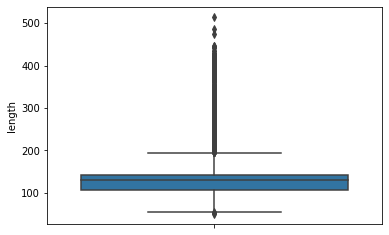

In [11]:
import seaborn as sns

# This is needed to make sure the plots are plotted within the notebook
%matplotlib inline  

sns.boxplot(y="length", data=full_df)

We can see, that the length is quite variable, but the majority appears to be between 100 and 150 nucleotides. 

Let's create the same plot again, but this time split the data among the x-axis into the three group. Simply use the same call from above, but pass `x="type"` as well.

<AxesSubplot: xlabel='type', ylabel='length'>

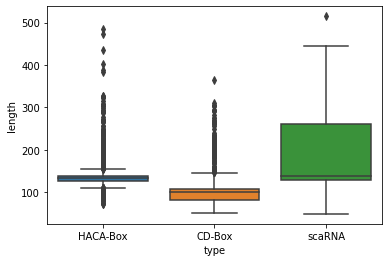

In [12]:
sns.boxplot(x="type", y="length", data=full_df)  


For the GC content, use the following formula: $GC(sequence) = (#G + #C) / length(sequence)$. The formula for the ATGC ratio is as following: $ATGC(sequence) = (#A + #T) / (#G + #C)$.
Again, we will use the `map()` function, but this time, we will have to create a `lambda` function, as there are no built-in functions to determine the two properties.

`lambda` functions are a neat way to create small temporary functions in a single line. They might appear a little tricky at first, but are very useful if used correctly. They work like this:

`lambda x: perform your function here`

Example: 

`full_df["sequence"].map(lambda x: len(x)*2+10)`

would create a new list with the length of each sequence multiplied by 2 and then increased by 10. Read more about lambda functions [here](https://www.w3schools.com/python/python_lambda.asp).

Let's create a lambda function that counts "G" and "C", adds them together, and then divides the result by the length. You can count the instances using the `.count()` function.

In [13]:
# Create GC_content column by counting G and C and dividing their sum by the length
full_df["GC_content"] = full_df["sequence"].map(lambda x: (x.count("G") + x.count("C")) / len(x))

Let's look at the data again

<AxesSubplot: xlabel='type', ylabel='GC_content'>

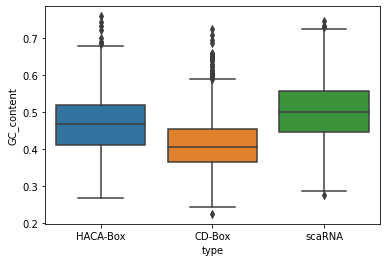

In [14]:
sns.boxplot(x="type", y="GC_content", data=full_df)

Repeat the same for the ATGC ratio

<AxesSubplot: xlabel='type', ylabel='ATGC_ratio'>

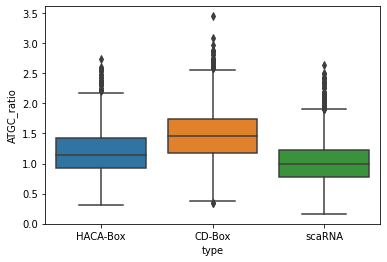

In [15]:
# Create the ATGC_ratio column by counting A+T and dividing by G+C
full_df["ATGC_ratio"] = full_df["sequence"].map(lambda x: (x.count("A") + x.count("T"))/(x.count("G") + x.count("C")))  # create a function that calculates (#A + #T)/(#G + #C)
sns.boxplot(x="type", y="ATGC_ratio", data=full_df)

### Let's plot our new properties combined

First, let's look at the plot of the combination of these features. Luckily, Seaborn's `pairplot()` method ([documentation](https://seaborn.pydata.org/generated/seaborn.pairplot.html)) does just what we need. We will add the dataframe, but only look at two classes at the time such that differences are more obvious. Let's start with CD and HACA. Make sure you add `hue="type"`, so that the different types will have different colors.


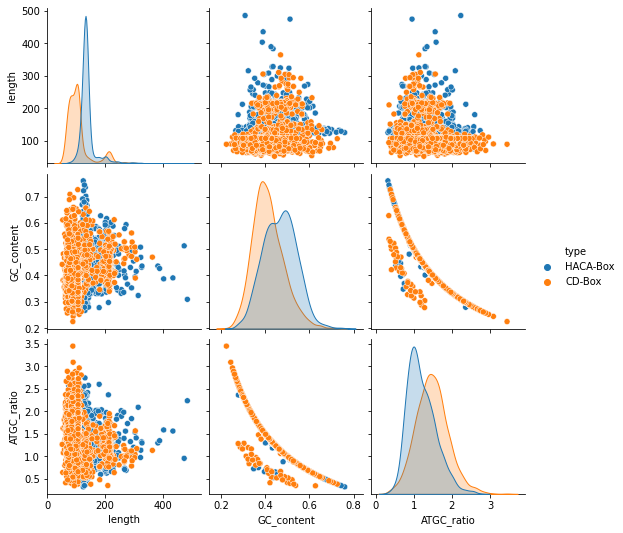

In [16]:
sns.pairplot(full_df.loc[(full_df.type != "scaRNA")], hue="type")

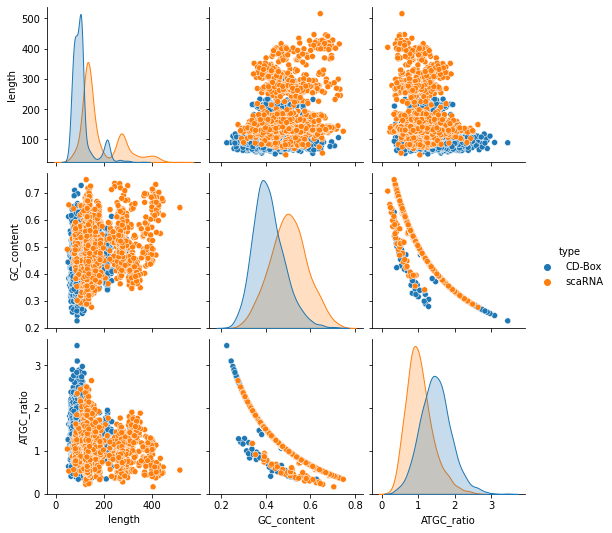

In [17]:
sns.pairplot(full_df.loc[(full_df.type != "HACA-Box")], hue="type")

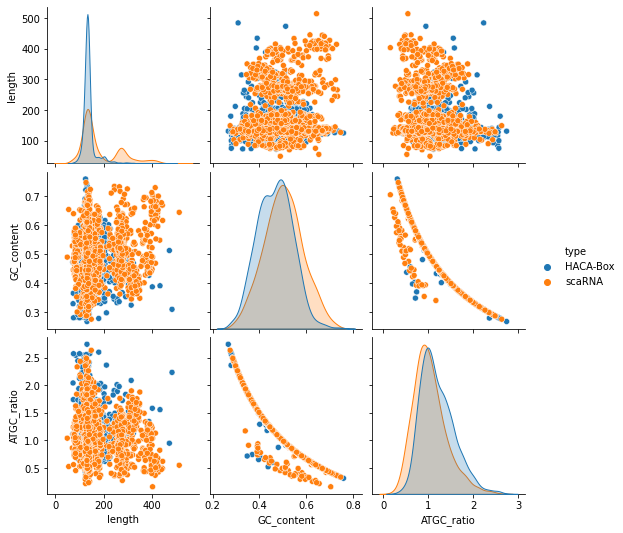

In [18]:
sns.pairplot(full_df.loc[(full_df.type != "CD-Box")], hue="type")


**Now we have some sequence features extracted and performed visual inspection of pairs of classes. What are your observations? Can you imagine some problems for our ML model later?**

Next we will try to find a baseline prediction, meaning how good can be a simple naive model using such features to predict the snoRNA and scaRNA classes.

### Creating a baseline how good ncRNA classification is by naive Bayes using the sequence properties

To split our data into train and test, we can use the `train_test_split()` method from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) .

The method outputs for things, X_train, X_test, Y_train and Y_test. 
X_train and X_test are the inputs for our models, in our case `full_df[["length"]]`* split into an 85%/15% ratio. Y_train and Y_test are the corresponding labels that we want our model to output. Since we want to classify by snoRNA type, the output is created from `full_df["type"]`. 

`test_size` needs to be set to 0.15 for a 85/15 split. `random_state` is the seed for the randomization. Set it to your favorite number. **NOTE: Make sure you always set the random_state to the same number whenever you split data into train and test. Otherwise, changes in the prediction might by attributed to different train/test splits**. Lastly, set `stratify` to the "type" column, such that all classes are distributed evenly by their type.

In [19]:
from sklearn.model_selection import train_test_split

# Split the training data for length into train and test set
X_train_length, X_test_length, Y_train, Y_test = train_test_split(full_df[["length"]],
                                                                  full_df["type"],
                                                                  test_size=0.15,
                                                                  random_state=1896, # Set random_state to your favorite number
                                                                  stratify=full_df["type"])


Text(0, 0.5, 'Number of Sequences')

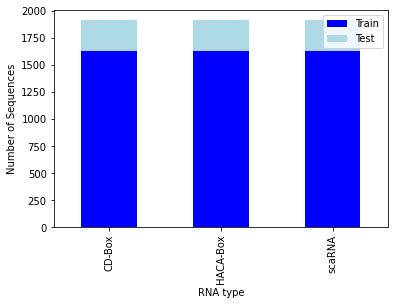

In [20]:
import matplotlib.pyplot as plt

# Create a dataframe with the number of samples of each class in train und test
train_test = pd.DataFrame({'Train': [list(Y_train).count("CD-Box"), list(Y_train).count("HACA-Box"),list(Y_train).count("scaRNA")],
                           'Test': [list(Y_test).count("CD-Box"), list(Y_test).count("HACA-Box"), list(Y_test).count("scaRNA")]},
                           index=['CD-Box', 'HACA-Box', 'scaRNA'])

# Plot in a barplot
train_test.plot(kind='bar', stacked=True, color=['blue', 'lightblue'])

plt.xlabel('RNA type')
plt.ylabel('Number of Sequences')

Now, we are ready to create our first predictor but it will be not based on the sequence itself but extracted sequence features. 

Let's classify the sequences using [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). Naive Bayes are very simple probabilistic classifiers. The model is trained on a so-called training set and then tested on a small subset of the data, which the model has never seen, the test set.

Import GaussianNB and create a classifier. We will try to train it on length first. Create an instant and then train it on the `"length"` column* of X_train using the `.fit()` method. We will also need to provide the Y_train vector, so the model knows what the correct labels are.

*NOTE: GaussianNB requires the input to be a dataframe. This means, instead of providing the column with `X_train["length"]`, you will have to use `X_train[["length"]]`

In [21]:
from sklearn.naive_bayes import GaussianNB

gnb_length = GaussianNB() # create classifier
gnb_length.fit(X_train_length, Y_train) # train using only length

GaussianNB()

Predict the test set using the `.predict()` method and `X_test[["length"]]`

In [22]:
prediction_length = gnb_length.predict(X_test_length) # generate predictions

Great! We created our first prediction. But how good is it? Let's look at the accuracy of our model. For this, we will import scikit-learn's `accuracy_score` metric. You can find how to calculate accuracy [here!](https://en.wikipedia.org/wiki/Accuracy_and_precision). We will first need to pass Y_test and then our prediction to the method. Afterwards, print the variable using an f-string.

In [23]:
from sklearn.metrics import accuracy_score

# Determine the accuracy of the prediction
accuracy_length = accuracy_score(Y_test, prediction_length)

# Print out the accuracy
print(f"The accuracy for Naive Bayes using length content is {accuracy_length}")


The accuracy for Naive Bayes using length content is 0.6736353077816493




Now we can try to compare it to the other sequence features we extracted like GC content or AT/GC ratio. Let's compare our prediction accuracy. See the code and let it run for GC_content. Use the following three empty boxes to do the same for the AT/GC ratio.



In [24]:
# Create Train and Test for the GC_content. Make sure you set random_state to the same number as before
X_train_gc, X_test_gc, Y_train, Y_test = train_test_split(full_df[["GC_content"]], full_df["type"], test_size=0.15, random_state=1896, stratify=full_df["type"])

In [25]:
gnb_gc = GaussianNB() # create classifier
gnb_gc.fit(X_train_gc, Y_train) # train using only GC content

GaussianNB()

In [26]:
# Predict the GC_content test set
prediction_gc = gnb_gc.predict(X_test_gc)

In [27]:
# Calculate and output the prediction
accuracy_gc = accuracy_score(Y_test, prediction_gc)
print(f"The accuracy for Naive Bayes using GC content is {accuracy_gc}")

The accuracy for Naive Bayes using GC content is 0.4959349593495935


In [28]:
# Create Train and Test for the ATGC_ratio. Make sure you set random_state to the same number as before
X_train_atgc, X_test_atgc, Y_train, Y_test = train_test_split(full_df[["ATGC_ratio"]], full_df["type"], test_size=0.15, random_state=1896, stratify=full_df["type"])

In [29]:
# Create the predictor and fit to the test data
gnb_atgc = GaussianNB()
gnb_atgc.fit(X_train_atgc, Y_train)

GaussianNB()

In [30]:
# Predict the test data
prediction_atgc = gnb_atgc.predict(X_test_atgc)

In [31]:
# Calculate and output the accuracy
accuracy_atgc = accuracy_score(Y_test, prediction_atgc)
print(f"The accuracy for Naive Bayes using AT/GC ration is {accuracy_atgc}")

The accuracy for Naive Bayes using AT/GC ration is 0.49477351916376305


### Look at the results in more detail

Accuracy gives a good general idea, how well a model performs, but what if we want to know individual results for each class? Scikit-learn provides a neat method for this called `classification_report()` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)). It outputs class-wise as well as over all [Precision, Recall](https://en.wikipedia.org/wiki/Precision_and_recall) and [F1-score](https://en.wikipedia.org/wiki/F-score).

Let's look at the classification report for our highest scoring prediction using just length (`prediction_length`). 

Additionally, we will save F1-score, Precision and Recall for each model, so we can compare all scores in the end in a single plot. 

Note, that these measures require that you used the same random state for each train/test split, so if you used different ones then set them to the same and rerun, such that the results are comparable.

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Print classifcation report
print(classification_report(Y_test, prediction_length))

# Save scores for later
f1_length = f1_score(Y_test, prediction_length, average="weighted")
prec_length = precision_score(Y_test, prediction_length, average="weighted")
rec_length = recall_score(Y_test, prediction_length, average="weighted")

              precision    recall  f1-score   support

      CD-Box       0.87      0.85      0.86       287
    HACA-Box       0.56      0.87      0.68       287
      scaRNA       0.65      0.30      0.41       287

    accuracy                           0.67       861
   macro avg       0.69      0.67      0.65       861
weighted avg       0.69      0.67      0.65       861



In [33]:
# Print classification report
print(classification_report(Y_test, prediction_gc))

# Save scres for later
f1_gc = f1_score(Y_test, prediction_gc, average="weighted")
prec_gc = precision_score(Y_test, prediction_gc, average="weighted")
rec_gc = recall_score(Y_test, prediction_gc, average="weighted")

              precision    recall  f1-score   support

      CD-Box       0.53      0.71      0.61       287
    HACA-Box       0.40      0.28      0.33       287
      scaRNA       0.51      0.51      0.51       287

    accuracy                           0.50       861
   macro avg       0.48      0.50      0.48       861
weighted avg       0.48      0.50      0.48       861



In [34]:
# Print classification report for the atgc prediction
print(classification_report(Y_test, prediction_atgc))

# Save the atgc prediction scores for later
f1_atgc = f1_score(Y_test, prediction_atgc, average="weighted")
prec_atgc = precision_score(Y_test, prediction_atgc, average="weighted")
rec_atgc = recall_score(Y_test, prediction_atgc, average="weighted")

              precision    recall  f1-score   support

      CD-Box       0.61      0.57      0.59       287
    HACA-Box       0.36      0.25      0.30       287
      scaRNA       0.48      0.67      0.56       287

    accuracy                           0.49       861
   macro avg       0.49      0.49      0.48       861
weighted avg       0.49      0.49      0.48       861




We see, that our Naive Bayes classifier for the sequence length is pretty good at identifying CD-Box, slightly worse for HACA-Box and pretty low scores for scaRNA. 
Also the comparison of the different features show huge differences in the sequence features and their accuracy.

From these reports we can make out, that HACA-Box has high recall, but lower precision, while scaRNA has very low recall. Missing are now important information if our model has in general a problem to predict a class or is it more a problem for some interconnected classes. Therefore we can use confusion matrices to directly see the true positives and false positives and their predicted label vs. the true label.


We can use sklearn's `confusion_matrix()` ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)). If we add `normalize="true"` the results are normalized over each row. To make it a little prettier, let's plot it as a heatmap, using seaborn again ([Documentation](https://seaborn.pydata.org/generated/seaborn.heatmap.html)). We need one intermediate step to transform the data into a dataframe, such that we can provide the heatmap with labels for the x- and y-axis.

<AxesSubplot: >

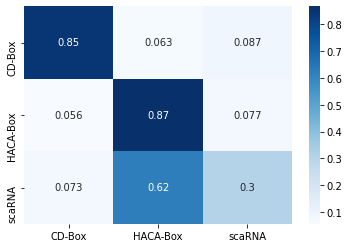

In [35]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
conf_matrix = confusion_matrix(Y_test, prediction_length, normalize="true")

# Turn matrix into a dataframe (necessary for plotting)
conf_df = pd.DataFrame(conf_matrix, index=["CD-Box", "HACA-Box", "scaRNA"], columns=["CD-Box", "HACA-Box", "scaRNA"])

# Plot the heatmap of the confusion
sns.heatmap(conf_df, annot=True, cmap="Blues")

### Create a classifier combining several sequence features to increase the prediction accuracy

Create more `GaussianNB()` classifiers by providing combinations of "AT/GC ratio", "length" and "GC_content". You can think of combining two features like "length" and "ATGC_ratio"or use all three values. 
You can access multiple columns at once by writing the column names in a list: `X_train[["length", "GC_content"]]`

In [36]:
# Split GC_content and length into train and test, make sure you set the random_state to the same number as before
X_train_length_gc, X_test_length_gc, Y_train, Y_test = train_test_split(full_df[["GC_content", "length"]], full_df["type"], test_size=0.15, random_state=1896, stratify=full_df["type"])

# create classifier and train using length and GC
gnb_length_gc = GaussianNB() 
gnb_length_gc.fit(X_train_length_gc, Y_train)

# generate predictions and output classification report
prediction_length_gc = gnb_length_gc.predict(X_test_length_gc) 
print(classification_report(Y_test, prediction_length_gc))

# Save scores for later
f1_length_gc = f1_score(Y_test, prediction_length_gc, average="weighted")
prec_length_gc = precision_score(Y_test, prediction_length_gc, average="weighted")
rec_length_gc = recall_score(Y_test, prediction_length_gc, average="weighted")

              precision    recall  f1-score   support

      CD-Box       0.73      0.79      0.76       287
    HACA-Box       0.54      0.72      0.61       287
      scaRNA       0.61      0.36      0.45       287

    accuracy                           0.62       861
   macro avg       0.63      0.62      0.61       861
weighted avg       0.63      0.62      0.61       861



In [37]:
# split the length and atgc data into train and test, don't forget to set the random_state to the same number as before
X_train_length_atgc, X_test_length_atgc, Y_train, Y_test = train_test_split(full_df[["ATGC_ratio", "length"]], full_df["type"], test_size=0.15, random_state=1896, stratify=full_df["type"])

# create classifier and train using length and atgc
gnb_length_atgc = GaussianNB() 
gnb_length_atgc.fit(X_train_length_atgc, Y_train)

# generate predictions and print classification report
prediction_length_atgc = gnb_length_atgc.predict(X_test_length_atgc) 
print(classification_report(Y_test, prediction_length_atgc))

# Save scores for later
f1_length_atgc = f1_score(Y_test, prediction_length_atgc, average="weighted")
prec_length_atgc = precision_score(Y_test, prediction_length_atgc, average="weighted")
rec_length_atgc = recall_score(Y_test, prediction_length_atgc, average="weighted")

              precision    recall  f1-score   support

      CD-Box       0.75      0.78      0.77       287
    HACA-Box       0.53      0.77      0.63       287
      scaRNA       0.63      0.32      0.43       287

    accuracy                           0.62       861
   macro avg       0.64      0.62      0.61       861
weighted avg       0.64      0.62      0.61       861



In [38]:
# Split all three measures into train/test
X_train_length_atgc_gc, X_test_length_atgc_gc, Y_train, Y_test = train_test_split(full_df[["ATGC_ratio", "length", "GC_content"]],
                                                                                  full_df["type"], test_size=0.15,
                                                                                  random_state=1896, stratify=full_df["type"])

# create classifier and train using all three measures
gnb_length_atgc_gc = GaussianNB() 
gnb_length_atgc_gc.fit(X_train_length_atgc_gc, Y_train)

# Predict and print classifcation report
prediction_length_atgc_gc = gnb_length_atgc_gc.predict(X_test_length_atgc_gc)
print(classification_report(Y_test, prediction_length_atgc_gc))

# Save scores for later
f1_length_atgc_gc = f1_score(Y_test, prediction_length_atgc_gc, average="weighted")
prec_length_atgc_gc = precision_score(Y_test, prediction_length_atgc_gc, average="weighted")
rec_length_atgc_gc = recall_score(Y_test, prediction_length_atgc_gc, average="weighted")

              precision    recall  f1-score   support

      CD-Box       0.70      0.74      0.72       287
    HACA-Box       0.54      0.66      0.59       287
      scaRNA       0.59      0.44      0.50       287

    accuracy                           0.61       861
   macro avg       0.61      0.61      0.60       861
weighted avg       0.61      0.61      0.60       861



**Which combination or single sequence feature has the highest accuracy so far? What does this mean for our future classifiers?**

Feature selection can often be tricky. It is important to plot the data and experiment with different inputs, to see what features might be useful for the prediction. What input variables do you feed into the model and what is your hypothesis? 

Let's also plot the different scores we saved, so we can compare all models together

[(0.3, 0.8)]

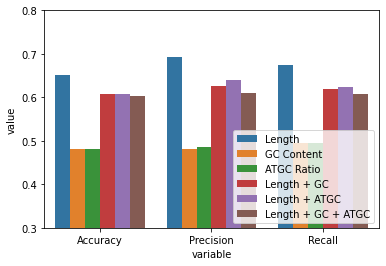

In [42]:
# Create dict with all the scores
dictionary = {"Accuracy": [f1_length, f1_gc, f1_atgc, f1_length_gc, f1_length_atgc, f1_length_atgc_gc],
              "Precision": [prec_length, prec_gc, prec_atgc, prec_length_gc, prec_length_atgc, prec_length_atgc_gc],
              "Recall": [rec_length, rec_gc, rec_atgc, rec_length_gc, rec_length_atgc, rec_length_atgc_gc],
              "Model": ["Length", "GC Content", "ATGC Ratio", "Length + GC", "Length + ATGC", "Length + GC + ATGC"]}

# Turn into dictionary for plotting
df = pd.DataFrame(dictionary)

# "melt" the dataframe (instead of multiple columns for the scores, we now have one column and a "variable" column that indicates which score is in this row)
df = pd.melt(df, id_vars=["Model"])

# Plot using a barplot
plot = sns.barplot(data=df, x="variable", y="value", hue="Model")
plt.legend(loc='lower right')
plot.set(ylim=(0.3, 0.8))

# Training CNNs to compare the accuracy with our ground truth

We already achieve an accuracy of around 67%, but there is still a lot of room for improvements. Deep learning or other, newer ML models can be a better choice for classification tasks where simple models like naive Bayes struggle or vice versa. For this reason in the next notebook we would like to optimize CNNs for our problem and compare it to our ground accuracy of ~67%.

## Now go to 2_cnn_classification.ipynb